In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import crystalball
from matplotlib import cm


from stripROtools import colors
from stripROtools import GetTransErrs
from stripROtools import Mismeasurment_vs_z
from stripROtools import random_three_vector
from stripROtools import plot_track

In [36]:
# Solid angle range in theta [degrees]
theta_min = 24
theta_max = 26



# Read dE/dx data from SRIM

In [37]:
# Load dEdx data simulated with SRIM
dEdx_data = np.loadtxt("./data/srim_po210_heco2.txt",skiprows=4)

dEdx_data = dEdx_data.T

# convert from angstrom to cm
dEdx_data[0] = dEdx_data[0]*1e-8

#dEdx resolution as seen in dEdx_data[0] 
delta_x = 0.1

# convert to eV/cm
dEdx_data[1] = dEdx_data[1]/1e-8
dEdx_data[2] = dEdx_data[2]/1e-8

dEdx = dEdx_data[1] + dEdx_data[2]




Text(0, 0.5, 'dE/dx [eV/cm] ')

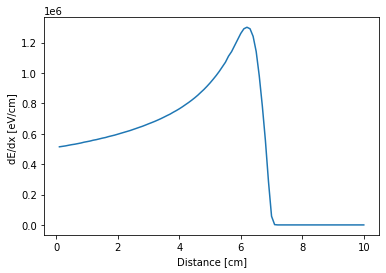

In [38]:
plt.plot(dEdx_data[0],dEdx)
plt.xlabel("Distance [cm]")
plt.ylabel("dE/dx [eV/cm] ")


# Simulate Po210 alpha tracks

In [39]:
# The paramters, in order, are:
# number of simulations
# minimum angle to vertical [degrees] - this is based  on requiring a min. of 5 hits
# maximum angle to vertical [degrees]
# drfit length [cm]
# Apply diffusion T/F
# Transverse diffusion coefficent from Magboltz [cm/sqrt(cm)]
# W-value as obtained using degrad

def sim_p210(n_sims = 100, theta_min = theta_min, theta_max = theta_max, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2):

    tracks = pd.DataFrame(columns = ['direction', 'start', 'track'])

    for i in range(n_sims):

        # draw a random direction within specified solid angle (pointing down towards the readout plane)
        v = random_three_vector(theta_min,theta_max)

        # Maximumm track length of alpha track
        L_max = -DL/v[2]

        # Length segments we will distribute charge on, 0.1 is the resolution of length of the SRIM simulation
        L_segments = np.arange(0,L_max+0.1,0.1)

        # Edges of the length segments we will distribute charge on (all edges are listed)
        L_edges = np.append(L_segments,L_max)

        # Energy deposited in each segment given dEdx (energy in each bin is listed)
        E_segments = dEdx[0:len(L_segments)]*np.diff(L_edges)

        # Compute corresponding number of ionizaed eletrons using energy deposited per segment divided by W-value
        Ne_segments = np.round(E_segments/W).astype("int")

        #find left and right edges for each bin
        Left_edges = L_segments[0:-1]
        Right_edges = L_segments[1:]

        track = np.empty((0,3))

        for N,left_edge,right_edge in zip(Ne_segments,Left_edges,Right_edges):

            Ts = np.random.uniform(low=left_edge,high=right_edge,size=N)

            if Diff == False:

                x_vals = Ts*v[0]
                y_vals = Ts*v[1]
                z_vals = DL + Ts*v[2]

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)
            
            elif Diff == True:

                z_vals = DL + Ts*v[2]

                x_vals = Ts*v[0] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                y_vals = Ts*v[1] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                z_vals = z_vals + DLong*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)

        x_rand = np.random.uniform()-0.5
        y_rand = np.random.uniform()-0.5

        track[:,0] = track[:,0]+x_rand # randomize x position (1 cm random uniform dist)
        track[:,1] = track[:,1]+y_rand # randomize x position (1 cm random uniform dist)

        tracks = tracks.append({'direction' : v, 'start' : np.array([x_rand,y_rand,DL]), 'track' : track }, ignore_index = True)

    return tracks




In [40]:
# Example of track simulation
tracks = sim_p210(n_sims = 100)
tracks.head()

,direction,start,track
0,"[-0.12378807405125193, -0.38894302738730546, -...","[-0.46666488781422555, -0.4819736219510786, 1.2]","[[-0.4718995999233537, -0.48111380681389476, 1..."
1,"[0.3871344707314801, 0.16652239040897493, -0.9...","[-0.28199267005001627, 0.1253995237463369, 1.2]","[[-0.28129566951097373, 0.11499865276467146, 1..."
2,"[-0.3778960783200539, -0.19732307488052017, -0...","[-0.17294338269709875, -0.11889357146931057, 1.2]","[[-0.18440597192143954, -0.1245579857897499, 1..."
3,"[0.07901166801445478, -0.42783354096219384, -0...","[0.1887910511195463, -0.47010981226991677, 1.2]","[[0.19611000765418052, -0.49278014636636214, 1..."
4,"[-0.41158694020999814, -0.10269878265166434, -...","[-0.3222631842739597, -0.4265604437936802, 1.2]","[[-0.36729625358838425, -0.4431376654715965, 1..."


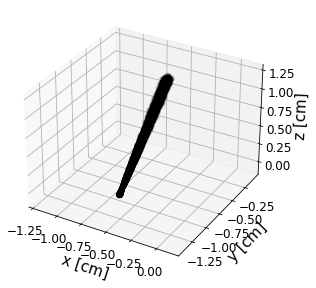

In [41]:
# Plot a Track
index = 0
track = tracks.iloc[index]["track"]
plot_track(track)

# Simulate readout


In [42]:
# the parameters, in order, are:
# peaking time [ns]
# digitization time [ns] 
# pitch of the x strips [um]
# pitch of the y strips [um]
# Threshold of x strips [No. electrons]
# Threshold of y strips [No. electrons]
# Charge sharing [lower strips / upper strips]
# Gain - extrapolating from PHA curve
# drift speed cm/ns
# Include charge integration effect.
# z resolution in cm, must be specified if Charge_integration = False
# Electronic gain in x [mV/fC]
# Electronic gain in y [mV/fC]

def sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = 200, pitch_y = 200,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = 0.41, Gain = 604, v_drift = 0.0008, Charge_integration = True, DL = 1.2, pitch_z = 0.02, G_x = 9.0, G_y = 4.5):

    #convert pitch to cm
    pitch_x = pitch_x * 1e-4
    pitch_y = pitch_y * 1e-4
    
    # Readout is 10 cm x 10 cm
    x_bins = np.arange(-5,5,pitch_x)
    y_bins = np.arange(-5,5,pitch_y)

    # Find strip edges in x and y
    Left_edges_x = x_bins[0:-1]
    Right_edges_x = x_bins[1:]
    Left_edges_y = y_bins[0:-1]
    Right_edges_y = y_bins[1:]


    hits = pd.DataFrame(columns = ['strips_x', 'strips_y', 'times_x', 'times_y','electrons_x','electrons_y'])

    for index, row in tracks.iterrows():

        track = row.track

        x_positions = []
        x_charges = []
        x_times = []
        adcs0 = []
        strips0 = []

        for L_edge,R_edge in zip(Left_edges_x,Right_edges_x):

            # Bin track over specific strip in x
            T_track = track[(track[:,0]> L_edge) &  (track[:,0]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):


                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) *Gain * CS / (CS+1.0)

                    if charge_detected > thres_x:
                        
                        # obtain mean time for the hit
                        x_times += [mean_time]
                        # obtain position of the hit
                        x_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips0 += [np.where(x_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        x_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs0 += [min( charge_detected/6241.5*G_x, 1023.0 ) ]

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,DL+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist *Gain * CS / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_x]
                    charge_detected = charge_detected [charge_detected>thres_x]


                    x_times += list(bin_centers/v_drift)
                    x_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    x_charges += list(charge_detected)

        

        y_positions = []
        y_charges = []
        y_times = []
        adcs1 = []
        strips1 = []

        for L_edge,R_edge in zip(Left_edges_y,Right_edges_y):

            # Bin track over specific strip in x
            T_track = track[(track[:,1]> L_edge) &  (track[:,1]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):

                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) * Gain / (CS+1.0)

                    if charge_detected > thres_y:

                        # obtain mean time for the hit
                        y_times += [mean_time]
                        # obtain position of the hit
                        y_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips1 += [np.where(y_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        y_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs1 += [ min( charge_detected/6241.5*G_y, 1023.0 ) ] # The min imposes saturation of ADC scale

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,DL+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist * Gain / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_y]
                    charge_detected = charge_detected [charge_detected>thres_y]


                    y_times += list(bin_centers/v_drift)
                    y_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    y_charges += list(charge_detected)

        hits = hits.append({'strips_x' : np.array(x_positions), 'strips0' : np.array(strips0),  'strips_y' : np.array(y_positions), 'strips1' : np.array(strips1), 'times_x' : np.array(x_times), 'times0' : np.array(x_times), 'times_y' : np.array(y_times), 'times1' : np.array(y_times), 'electrons_x' :  np.array(x_charges), 'adcs0' :  np.array(adcs0), 'electrons_y' : np.array(y_charges), 'adcs1' :  np.array(adcs1) }, ignore_index = True)
        
    return hits


In [43]:
# Example of readout simulation
hits = sim_readout(tracks)
tracks = pd.concat([tracks,hits],axis=1)
tracks.head()


,direction,start,track,strips_x,strips_y,times_x,times_y,electrons_x,electrons_y,adcs0,adcs1,strips0,strips1,times0,times1
0,"[-0.12378807405125193, -0.38894302738730546, -...","[-0.46666488781422555, -0.4819736219510786, 1.2]","[[-0.4718995999233537, -0.48111380681389476, 1...","[-0.6300000000000932, -0.6100000000000936, -0....","[-1.0300000000000846, -1.010000000000085, -0.9...","[-3.6565687176512824, 157.1787294973736, 285.2...","[-87.05793450582206, -49.89209596705789, 9.622...","[408166.9219858156, 329484.1418439716, 159473....","[116944.68085106384, 352975.88652482274, 35040...","[588.5608103616663, 475.10330474977883, 229.95...","[84.31483839298042, 254.48874298833653, 252.63...","[218, 219, 220, 221, 222]","[198, 199, 200, 201, 202, 203, 204, 205, 206, ...","[-3.6565687176512824, 157.1787294973736, 285.2...","[-87.05793450582206, -49.89209596705789, 9.622..."
1,"[0.3871344707314801, 0.16652239040897493, -0.9...","[-0.28199267005001627, 0.1253995237463369, 1.2]","[[-0.28129566951097373, 0.11499865276467146, 1...","[-0.2700000000001008, -0.25000000000010125, -0...","[0.14999999999989022, 0.1699999999998898, 0.18...","[1447.120493370854, 1394.936366987018, 1340.21...","[1186.1974585810924, 1065.5067903601014, 935.5...","[103446.78014184398, 117672.90780141843, 11661...","[128082.26950354611, 147358.86524822697, 15164...","[149.16622947634315, 169.67975169634957, 168.1...","[92.34482300183569, 106.2428732863929, 109.331...","[236, 237, 238, 239, 240, 241, 242, 243, 244, ...","[257, 258, 259, 260, 261, 262, 263, 264, 265, ...","[1447.120493370854, 1394.936366987018, 1340.21...","[1186.1974585810924, 1065.5067903601014, 935.5..."
2,"[-0.3778960783200539, -0.19732307488052017, -0...","[-0.17294338269709875, -0.11889357146931057, 1.2]","[[-0.18440597192143954, -0.1245579857897499, 1...","[-0.6900000000000919, -0.6700000000000923, -0....","[-0.39000000000009827, -0.3700000000000987, -0...","[-47.242591409379834, 12.330010278485044, 74.1...","[-38.05398542100382, 66.02471438180201, 176.79...","[148057.10638297873, 148759.63120567377, 15192...","[540601.4184397163, 691387.2340425532, 661401....","[213.49258310451148, 214.5055965474748, 219.06...","[389.76309909136, 498.4767368727853, 476.85754...","[215, 216, 217, 218, 219, 220, 221, 222, 223, ...","[230, 231, 232, 233, 234, 235, 236, 237, 238, ...","[-47.242591409379834, 12.330010278485044, 74.1...","[-38.05398542100382, 66.02471438180201, 176.79..."
3,"[0.07901166801445478, -0.42783354096219384, -0...","[0.1887910511195463, -0.47010981226991677, 1.2]","[[0.19611000765418052, -0.49278014636636214, 1...","[0.2499999999998881, 0.26999999999988766, 0.28...","[-1.0700000000000838, -1.0500000000000842, -1....","[409.21381555636844, 226.88384202901491, 25.11...","[-62.72775208883531, -27.136107969132688, 27.7...","[76750.83687943262, 225861.7304964539, 452777....","[149929.0780141844, 307568.7943262411, 334556....","[110.67171864373846, 325.6838219126949, 652.88...","[108.0959466576672, 221.75111342915727, 241.20...","[262, 263, 264]","[196, 197, 198, 199, 200, 201, 202, 203, 204, ...","[409.21381555636844, 226.88384202901491, 25.11...","[-62.72775208883531, -27.136107969132688, 27.7..."
4,"[-0.41158694020999814, -0.10269878265166434, -...","[-0.3222631842739597, -0.4265604437936802, 1.2]","[[-0.36729625358838425, -0.4431376654715965, 1...","[-0.8900000000000876, -0.870000000000088, -0.8...","[-0.5700000000000944, -0.5500000000000949, -0....","[-58.69973483831954, -6.59409410481927, 49.222...","[-20.608042524407836, 93.47830387712409, 264.1...","[118199.80141843972, 140856.2269503546, 140329...","[733795.7446808511, 734224.1134751773, 396241....","[170.43951177857204, 203.10919531413788, 202.3...","[529.0524474988111, 529.3612930606902, 285.682...","[205, 206, 207, 208, 209, 210, 211, 212, 213, ...","[221, 222, 223, 224]","[-58.69973483831954, -6.59409410481927, 49.222...","[-20.608042524407836, 93.47830387712409, 264.1..."


# Perform 3D Reconstruction

[   0.           59.57260169  121.36570686  180.41443787  241.47541885
  300.35359506  362.45270201  421.37436055  480.18632298  540.3092445
  599.71565122  658.91580535  719.00220523  774.02364192  838.35253015
  894.76137152  954.99888968 1012.50841011 1071.69102016 1136.64213374
 1188.93362708 1250.93034885 1306.0571703  1365.75351069 1413.80336956
 1476.86279709 1513.65696625]


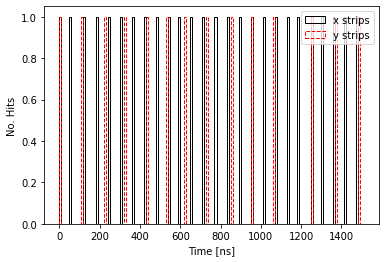

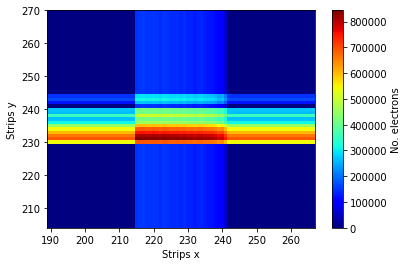

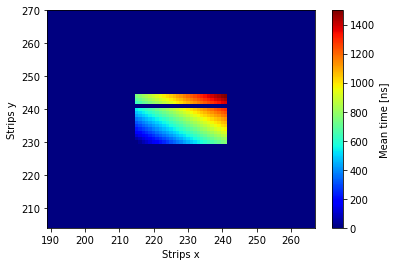

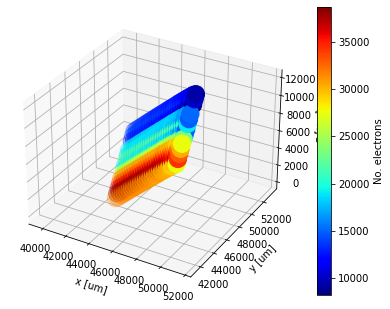

/Users/majdghrear/Lab/2DstripRO/stripROtools.py:663: RuntimeWarning: invalid value encountered in reciprocal
  abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)


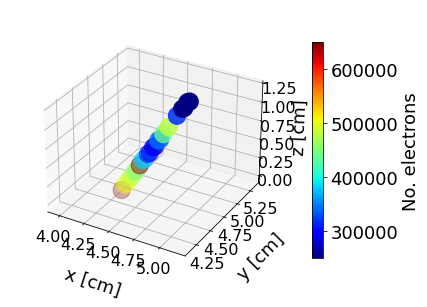

In [80]:
# 3D clustering paramters
mu = -6.684141
sigma = 16.382493
n_sigma = 3

# Look at a single event after the cut
test_event = tracks.iloc[2] # 2, 9
# Make a TrackTools object for the event
dsp = stripROtools.TrackTools(event = test_event, Mult_factor = 1.0, gain_x=9, gain_y=4.5, v_drift=8.0)

# Plot 1D time display
dsp.TimeHistView( t_bin =10)

# Plot 2D displays of charge and time
dsp.Strip2DView(fullview = False)
dsp.Strip2DView_times(fullview = False)

# Plot 3D displays
dsp.Reconst3D_v0()
x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma,save_name = "sim_alpha")

# Make voxel plot

In [81]:
# Get principal axis and center of charge
z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)

In [82]:
def make_voxel_plot(x,y,z,c,v_PA,x_b,save_name):

    # Find initial t parameter to draw principal axis
    ti = -x_b[2]/v_PA[2]

    # Find final parameter to draw principal axis
    tf=(np.max(z)-x_b[2])/v_PA[2]

    # Start and stop point of fitted line
    start = x_b + (ti*v_PA)
    stop = x_b + (tf*v_PA)

    # transform coord
    xi = (start[0]-np.min(x))/200 
    yi = (start[1]-np.min(y))/200
    zi = (start[2]-np.min(z))/200

    xf = (stop[0]-np.min(x))/200 
    yf = (stop[1]-np.min(y))/200
    zf = (stop[2]-np.min(z))/200

    x = np.round((x-np.min(x))/200).astype(int)
    y = np.round((y-np.min(y))/200).astype(int)
    z = np.round((z-np.min(z))/200).astype(int)

    # Empty array to store tensor
    tensor = np.zeros(shape=(np.max(x)+1,np.max(y)+1,np.max(z)+1))

    # Loop through track and update tensor
    for xj, yj, zj, cj in zip(x,y,z,c):

        tensor[xj][yj][zj] = cj

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('x strip',labelpad = 40,fontsize=25)
    ax.set_ylabel('y strip',labelpad = 40,fontsize=25)
    ax.set_zlabel('z bin',labelpad = 40,fontsize=25)
    ax.tick_params(labelsize=20)
    ax.tick_params(direction='out', pad=20)
    ax.set_box_aspect(None, zoom=0.85)


    cmap = plt.get_cmap("viridis")
    norm= plt.Normalize(0.0, 700000)


    ax.voxels(tensor,facecolors=cmap(norm(tensor)),alpha=1)

    ax.plot([xi,xf], [yi,yf], [zi,zf], color='k')

    m = cm.ScalarMappable(cmap=cmap, norm=norm)
    m.set_array([])
    cbar = plt.colorbar(m,fraction=0.03, pad=0.07)
    cbar.set_label(label='No. electrons',size=25)
    cbar.ax.tick_params(labelsize=20)

    stripROtools.set_axes_equal(ax)
    plt.tight_layout()
    plt.savefig("./figures/"+save_name+".pdf")




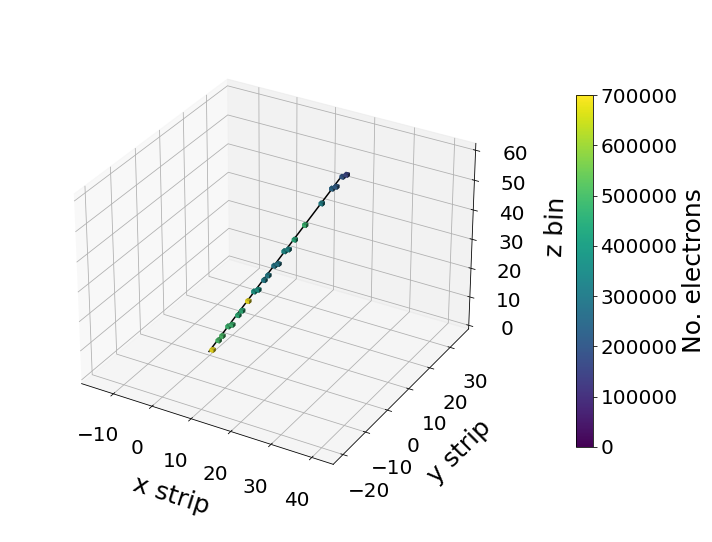

In [83]:
make_voxel_plot(x,y,z,c,v_PA,x_b,"sim_alpha")